In [1]:
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install kagglehub
!pip install opencv-python
!pip install matplotlib
!pip install tqdm

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from tqdm import tqdm
import collections
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
import random
from google.colab import drive, files

In [4]:
import kagglehub
import os

In [5]:
# Download the dataset
dataset_path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")
print("Path to dataset files:", dataset_path)

# --- Path Correction Logic (Fixes FileNotFoundError) ---
# The actual data root might be nested inside the downloaded folder.
expected_data_dir = os.path.join(dataset_path, "OCT2017", "Dataset - train+val+test")

if os.path.exists(expected_data_dir):
    DATA_ROOT = expected_data_dir
else:
    # Fallback check if the files were flattened
    DATA_ROOT = os.path.join(dataset_path, "Dataset - train+val+test")

if not os.path.exists(DATA_ROOT):
    print("Warning: Could not find the expected data directory structure.")
    print("Please manually check the contents of:", dataset_path)

print("Data Root Directory:", DATA_ROOT)

100%|██████████| 6.70G/6.70G [01:01<00:00, 118MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2
Data Root Directory: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2/Dataset - train+val+test


In [6]:
# Define paths to dataset splits using the corrected DATA_ROOT from Cell 2
train_dir = os.path.join(DATA_ROOT, "train")
val_dir = os.path.join(DATA_ROOT, "val")
test_dir = os.path.join(DATA_ROOT, "test")

# Verify the classes (folders) in each directory
print("Train classes:", os.listdir(train_dir))
print("Validation classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))

def count_per_class(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

print("\nTrain Counts:", count_per_class(train_dir))
print("Validation Counts:", count_per_class(val_dir))
print("Test Counts:", count_per_class(test_dir))

Train classes: ['NORMAL', 'DME', 'DRUSEN', 'CNV']
Validation classes: ['NORMAL', 'DME', 'DRUSEN', 'CNV']
Test classes: ['NORMAL', 'DME', 'DRUSEN', 'CNV']

Train Counts: {'NORMAL': 35973, 'DME': 8118, 'DRUSEN': 6206, 'CNV': 26218}
Validation Counts: {'NORMAL': 10278, 'DME': 2319, 'DRUSEN': 1773, 'CNV': 7491}
Test Counts: {'NORMAL': 5139, 'DME': 1161, 'DRUSEN': 887, 'CNV': 3746}


In [7]:
# Standard ImageNet normalization parameters
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# No augmentation for validation/test
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the datasets using the corrected directory paths
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_transforms)
test_data = datasets.ImageFolder(test_dir, transform=val_transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_data.samples)}")
print(f"Validation dataset size: {len(val_data.samples)}")
print(f"Test dataset size: {len(test_data.samples)}")

print("Class indices:", train_data.class_to_idx)

Train dataset size: 76515
Validation dataset size: 21861
Test dataset size: 10933
Class indices: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [8]:
### Cell 8: Define the MobileNetV3 Large Model (Transfer Learning)
class MobileNetV3Custom(nn.Module):
    """
    A custom wrapper around a pretrained MobileNetV3 Large model for 4-class classification.
    """
    def __init__(self, num_classes=4, freeze_features=False):
        super(MobileNetV3Custom, self).__init__()

        # Load pre-trained MobileNetV3 Large weights
        weights = MobileNet_V3_Large_Weights.DEFAULT
        self.model = mobilenet_v3_large(weights=weights)

        if freeze_features:
            # Freeze all the feature extraction layers
            for param in self.model.features.parameters():
                param.requires_grad = False

        # Modify the final classification layer (classifier)
        # MobileNetV3's classifier is an nn.Sequential object
        num_ftrs = self.model.classifier[-1].in_features
        # Use 1280 (default output of MobileNetV3 Large features before the final classifier)
        self.model.classifier[-1] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.Hardswish(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

print("MobileNetV3 Large model with modified final classification layer defined.")

MobileNetV3 Large model with modified final classification layer defined.


In [9]:
### Cell 9: Training Setup
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization
model = MobileNetV3Custom(num_classes=len(train_data.classes), freeze_features=False).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

print('Device:', device)
print('Model initialized with', len(train_data.classes), 'classes.')
print('Optimizer targeting', len(list(filter(lambda p: p.requires_grad, model.parameters()))), 'trainable parameters.')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 128MB/s] 


Device: cuda
Model initialized with 4 classes.
Optimizer targeting 176 trainable parameters.


In [10]:
### Cell 10: Training Loop and Intermediate Results/Grad-CAM
# Mount Google Drive to save results
drive.mount('/content/drive')
results_dir = "/content/drive/MyDrive/OCT_MobileNetV3_Large_Visualization"
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Denormalize function (reverses ImageNet normalization)
mean_t = torch.tensor(mean).view(3, 1, 1)
std_t = torch.tensor(std).view(3, 1, 1)

def denormalize(img_tensor: torch.Tensor) -> torch.Tensor:
    """Reverses the normalization for visualization."""
    return img_tensor * std_t.to(img_tensor.device) + mean_t.to(img_tensor.device)

def fmap_to_heatmap(fmap: torch.Tensor):
    """Converts a feature map tensor to a normalized heatmap numpy array."""
    fmap_np = fmap.mean(dim=0).cpu().numpy() # Mean across channels

    # Min-Max scaling to [0, 1]
    min_val = fmap_np.min()
    max_val = fmap_np.max()
    if max_val == min_val:
        return np.zeros_like(fmap_np, dtype=np.float32)
    return (fmap_np - min_val) / (max_val - min_val)

# Prepare mapping for sampling
paths_by_label = {i: [] for i in range(len(train_data.classes))}
for path, label in train_data.samples:
    paths_by_label[label].append(path)

# Create index-to-class name map
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}

# Grad-CAM Setup (Forward Hooks for MobileNetV3 Large)
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Hook target layers for MobileNetV3 Large:
# 'conv1': The very first conv layer (early features) - Index 0 of features
h1 = model.model.features[0].register_forward_hook(get_activation("conv1"))
# 'conv_last': The last block of the features (late features) - Index 16 of features (final bneck)
h2 = model.model.features[16].register_forward_hook(get_activation("conv_last"))


num_epochs = 10
print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    epoch_acc = correct_train / total_train
    print(f"\nEpoch {epoch+1} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    # Intermediate Visualization Phase
    model.eval()
    epoch_folder = os.path.join(results_dir, f"epoch_{epoch+1:02d}")
    os.makedirs(epoch_folder, exist_ok=True)

    selected = {}
    for label_idx, paths in paths_by_label.items():
        k = min(5, len(paths))
        selected[label_idx] = random.sample(paths, k)

    with torch.no_grad():
        for label_idx, paths in selected.items():
            for i, img_path in enumerate(paths):
                # 1. Prepare image
                img = Image.open(img_path).convert("RGB")
                x = val_transforms(img).unsqueeze(0).to(device)

                # 2. Forward pass to get activations and prediction
                logits = model(x)
                probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
                pred_idx = torch.argmax(logits, dim=1).item()

                # 3. Retrieve and convert feature maps to heatmaps
                # MobileNetV3 early features: output of first block
                conv1 = activations.get("conv1")
                hm1 = fmap_to_heatmap(conv1[0])
                # MobileNetV3 late features: output of last feature block
                conv_last = activations.get("conv_last")
                hm_last = fmap_to_heatmap(conv_last[0])

                # 4. Visualization and Saving
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                fig.suptitle(f"Epoch {epoch+1} | True: {idx_to_class.get(label_idx)} | Pred: {idx_to_class.get(pred_idx)} ({probs[pred_idx]*100:.1f}%)", fontsize=16)

                # MobileNet input requires upsampling of feature maps for overlay
                hm1_resized = cv2.resize(hm1, (224, 224))
                hm_last_resized = cv2.resize(hm_last, (224, 224))

                # Display Denormalized Input Image
                input_img_np = denormalize(x[0]).permute(1, 2, 0).cpu().numpy().clip(0, 1)

                # Plot Original
                axs[0].imshow(input_img_np)
                axs[0].set_title("Input Image")
                axs[0].axis('off')

                # Plot Early Features Overlay
                axs[1].imshow(input_img_np)
                axs[1].imshow(hm1_resized, cmap='jet', alpha=0.5)
                axs[1].set_title("Early Features (features[0])")
                axs[1].axis('off')

                # Plot Late Features Overlay
                axs[2].imshow(input_img_np)
                axs[2].imshow(hm_last_resized, cmap='jet', alpha=0.5)
                axs[2].set_title("Late Features (features[16])")
                axs[2].axis('off')

                # Save plot
                class_name = idx_to_class.get(label_idx)
                out_path = os.path.join(epoch_folder, f"{class_name}_{i:02d}.png")
                plt.tight_layout()
                plt.savefig(out_path, dpi=100)
                plt.close(fig)

# Cleanup: Remove hooks after training
h1.remove()
h2.remove()

Mounted at /content/drive
Results will be saved to: /content/drive/MyDrive/OCT_MobileNetV3_Large_Visualization
Starting training for 10 epochs...


Epoch 1/10 Training: 100%|██████████| 2392/2392 [08:38<00:00,  4.62it/s]



Epoch 1 - Loss: 0.1866, Acc: 0.9413


Epoch 2/10 Training: 100%|██████████| 2392/2392 [08:01<00:00,  4.97it/s]



Epoch 2 - Loss: 0.1402, Acc: 0.9564


Epoch 3/10 Training: 100%|██████████| 2392/2392 [07:46<00:00,  5.13it/s]



Epoch 3 - Loss: 0.1261, Acc: 0.9605


Epoch 4/10 Training: 100%|██████████| 2392/2392 [07:47<00:00,  5.11it/s]



Epoch 4 - Loss: 0.1183, Acc: 0.9624


Epoch 5/10 Training: 100%|██████████| 2392/2392 [07:51<00:00,  5.07it/s]



Epoch 5 - Loss: 0.1118, Acc: 0.9645


Epoch 6/10 Training: 100%|██████████| 2392/2392 [07:42<00:00,  5.17it/s]



Epoch 6 - Loss: 0.1072, Acc: 0.9654


Epoch 7/10 Training: 100%|██████████| 2392/2392 [07:43<00:00,  5.16it/s]



Epoch 7 - Loss: 0.1035, Acc: 0.9659


Epoch 8/10 Training: 100%|██████████| 2392/2392 [07:44<00:00,  5.15it/s]



Epoch 8 - Loss: 0.1036, Acc: 0.9665


Epoch 9/10 Training: 100%|██████████| 2392/2392 [07:43<00:00,  5.16it/s]



Epoch 9 - Loss: 0.0976, Acc: 0.9681


Epoch 10/10 Training: 100%|██████████| 2392/2392 [07:43<00:00,  5.16it/s]



Epoch 10 - Loss: 0.0969, Acc: 0.9680


In [11]:
### Cell 11: Save Trained Model
# Define save path
save_path = "/content/mobilenetv3_large_oct_best01.pth"

# Get class index mapping
class_to_idx = train_data.class_to_idx

# Save model state dictionary and class mapping
torch.save({
    "state_dict": model.state_dict(),
    "class_to_idx": class_to_idx
}, save_path)

print(f"Trained MobileNetV3 Large model saved to {save_path}")

Trained MobileNetV3 Large model saved to /content/mobilenetv3_large_oct_best01.pth


In [12]:
def evaluate(model, loader, class_names, device):
    """Calculates accuracy, confusion matrix, and classification report."""
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=class_names, digits=4)

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)

    return accuracy

# Load the saved model for evaluation
ckpt_path = "/content/mobilenetv3_large_oct_best01.pth"
checkpoint = torch.load(ckpt_path, map_location=device)

# Instantiate the model structure
model_eval = MobileNetV3Custom(num_classes=len(train_data.classes)).to(device)
model_eval.load_state_dict(checkpoint["state_dict"])
model_eval.eval()

# Get class names
class_names = [k for k, v in sorted(train_data.class_to_idx.items(), key=lambda item: item[1])]

print("== Validation on MobileNetV3 Large ==")
val_acc = evaluate(model_eval, val_loader, class_names, device)

print("\n== Testing on MobileNetV3 Large ==")
test_acc = evaluate(model_eval, test_loader, class_names, device)

== Validation on MobileNetV3 Large ==


Evaluating: 100%|██████████| 684/684 [02:04<00:00,  5.48it/s]



Accuracy: 0.9648

Confusion Matrix:
 [[ 7217    45   221     8]
 [   67  2074    17   161]
 [   90     2  1609    72]
 [   11     9    67 10191]]

Classification Report:
               precision    recall  f1-score   support

         CNV     0.9773    0.9634    0.9703      7491
         DME     0.9737    0.8944    0.9323      2319
      DRUSEN     0.8406    0.9075    0.8728      1773
      NORMAL     0.9769    0.9915    0.9842     10278

    accuracy                         0.9648     21861
   macro avg     0.9421    0.9392    0.9399     21861
weighted avg     0.9656    0.9648    0.9649     21861


== Testing on MobileNetV3 Large ==


Evaluating: 100%|██████████| 342/342 [01:03<00:00,  5.42it/s]


Accuracy: 0.9650

Confusion Matrix:
 [[3611   31   98    6]
 [  24 1048   15   74]
 [  37    1  800   49]
 [   3   10   35 5091]]

Classification Report:
               precision    recall  f1-score   support

         CNV     0.9826    0.9640    0.9732      3746
         DME     0.9615    0.9027    0.9311      1161
      DRUSEN     0.8439    0.9019    0.8719       887
      NORMAL     0.9753    0.9907    0.9829      5139

    accuracy                         0.9650     10933
   macro avg     0.9408    0.9398    0.9398     10933
weighted avg     0.9657    0.9650    0.9651     10933



In [13]:
### Cell 15: Count Model Parameters
# Instantiate the MobileNetV3 Large model structure
model = MobileNetV3Custom(num_classes=4)

# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters (MobileNetV3 Large): {total_params:,}")
print(f"Number of trainable parameters: {trainable_params:,}")

Total number of parameters (MobileNetV3 Large): 4,859,956
Number of trainable parameters: 4,859,956


In [14]:
### Cell 16: Calculate Model Size
# Calculate total size of model in bytes
param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())

# Convert to MB
model_size_mb = param_size_bytes / (1024**2)

print(f"Model size: {model_size_mb:.2f} MB")

Model size: 18.54 MB


Please upload an OCT image file (.jpeg, .png) for prediction and Grad-CAM visualization.


Saving CNV-1016042-185.jpeg to CNV-1016042-185.jpeg
Saving DME-119840-13.jpeg to DME-119840-13.jpeg
Saving DRUSEN-1173253-12.jpeg to DRUSEN-1173253-12.jpeg
Saving NORMAL-1071418-6.jpeg to NORMAL-1071418-6.jpeg


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


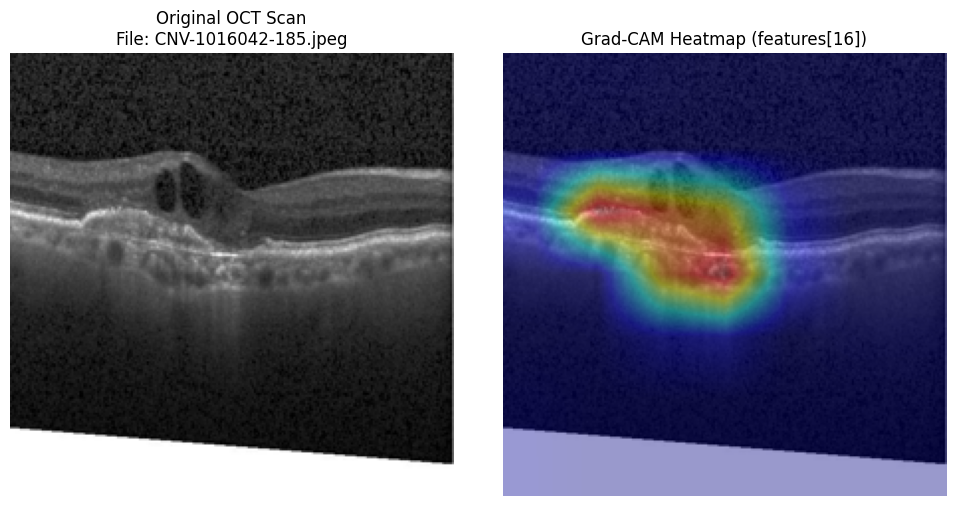


--- AI-Based Biomarker Detection (MobileNetV3 Large) ---
Predicted Class: **CNV**
Confidence: **99.45%**
Biomarker Detected: **Choroidal Neovascularization (CNV)**
Associated Ocular Disease: **Wet Age-Related Macular Degeneration (AMD)**
All Probabilities: CNV: 99.45%, DME: 0.52%, DRUSEN: 0.02%, NORMAL: 0.00%



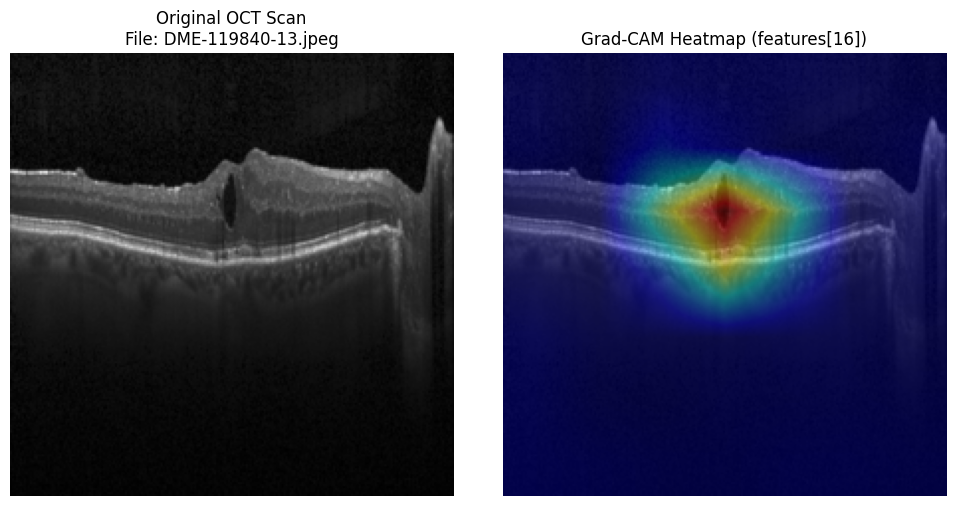


--- AI-Based Biomarker Detection (MobileNetV3 Large) ---
Predicted Class: **DME**
Confidence: **99.56%**
Biomarker Detected: **Diabetic Macular Edema (DME)**
Associated Ocular Disease: **Diabetic Retinopathy**
All Probabilities: CNV: 0.05%, DME: 99.56%, DRUSEN: 0.01%, NORMAL: 0.39%



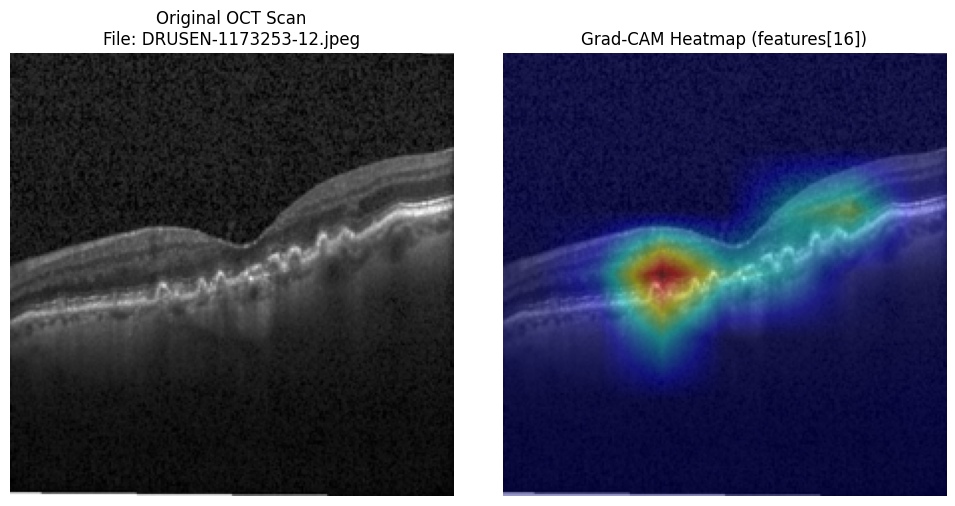


--- AI-Based Biomarker Detection (MobileNetV3 Large) ---
Predicted Class: **DRUSEN**
Confidence: **92.21%**
Biomarker Detected: **Drusen**
Associated Ocular Disease: **Dry Age-Related Macular Degeneration (AMD)**
All Probabilities: CNV: 7.76%, DME: 0.02%, DRUSEN: 92.21%, NORMAL: 0.01%



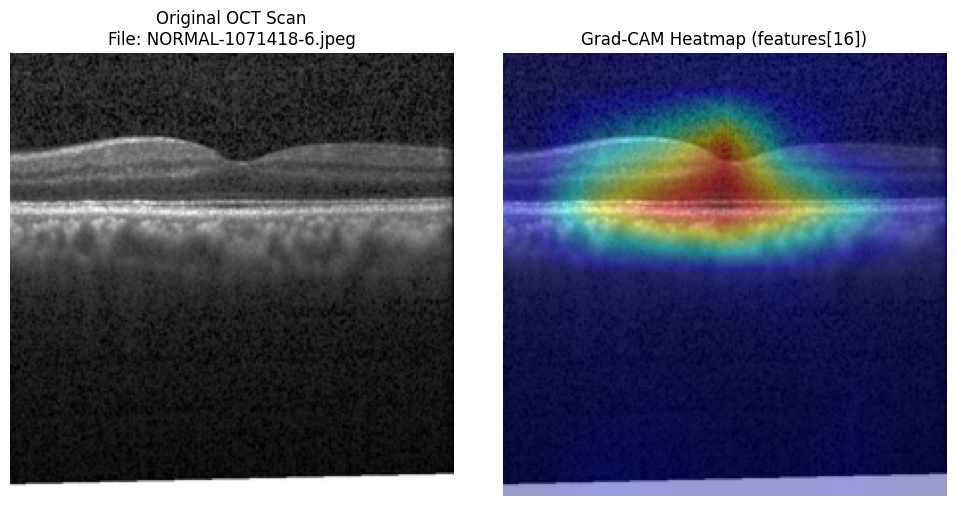


--- AI-Based Biomarker Detection (MobileNetV3 Large) ---
Predicted Class: **NORMAL**
Confidence: **100.00%**
Biomarker Detected: **No significant biomarkers detected**
Associated Ocular Disease: **Normal Retina**
All Probabilities: CNV: 0.00%, DME: 0.00%, DRUSEN: 0.00%, NORMAL: 100.00%



In [15]:
# Re-define the model structure for inference environment (redundant if cells are run sequentially, but good practice)
class MobileNetV3Custom(nn.Module):
    def __init__(self, num_classes=4, freeze_features=False):
        super(MobileNetV3Custom, self).__init__()
        weights = MobileNet_V3_Large_Weights.DEFAULT
        self.model = mobilenet_v3_large(weights=weights)
        if freeze_features:
            for param in self.model.features.parameters():
                param.requires_grad = False
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.Hardswish(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# Data preprocessing transformations
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Model Loading
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = "/content/mobilenetv3_large_oct_best01.pth"

checkpoint = torch.load(ckpt_path, map_location=device)
model = MobileNetV3Custom(num_classes=len(checkpoint["class_to_idx"])).to(device)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# Class mapping
class_to_idx = checkpoint["class_to_idx"]
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Biomarker/Disease Mapping
biomarker_map = {
    'CNV': 'Choroidal Neovascularization (CNV)',
    'DME': 'Diabetic Macular Edema (DME)',
    'DRUSEN': 'Drusen',
    'NORMAL': 'No significant biomarkers detected'
}

disease_map = {
    'CNV': 'Wet Age-Related Macular Degeneration (AMD)',
    'DME': 'Diabetic Retinopathy',
    'DRUSEN': 'Dry Age-Related Macular Degeneration (AMD)',
    'NORMAL': 'Normal Retina'
}

# Grad-CAM Implementation
class GradCAM:
    """Class to implement Grad-CAM visualization."""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        # Register hooks to the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, class_idx):
        # Pool the gradients across the spatial dimensions
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute CAM: dot product of weights and activations
        cam = weights * self.activations
        cam = torch.sum(cam, dim=1).squeeze()

        # Apply ReLU to retain only positive contributions
        cam = torch.relu(cam)

        # Normalize the CAM to [0, 1]
        cam_min, cam_max = cam.min(), cam.max()
        if cam_max != cam_min:
            cam = (cam - cam_min) / (cam_max - cam_min)
        else:
            cam = torch.zeros_like(cam)

        return cam.cpu().numpy()

def predict_image(image_path, model, idx_to_class, class_to_idx, transform, threshold=0.90, show_probs=True, device='cpu'):
    """Performs prediction and Grad-CAM visualization for a single image."""

    # 1. Image Preprocessing
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        return f"Error opening image: {e}"

    x = transform(img).unsqueeze(0).to(device)

    # 2. Setup Grad-CAM - Target: The last convolutional block (features[16])
    target_layer = model.model.features[16]
    gradcam = GradCAM(model, target_layer)

    # 3. Forward Pass
    logits = model(x)
    probs = torch.softmax(logits, dim=1).detach().cpu().numpy()[0]
    pred_idx = torch.argmax(logits, dim=1).item()
    conf = probs[pred_idx]
    pred_class = idx_to_class[pred_idx]

    if conf < threshold:
        return (f"Warning: Model confidence ({conf*100:.2f}%) is below the threshold. "
                f"Prediction: {pred_class} | Probabilities: {probs}")

    # 4. Backward Pass for Grad-CAM
    model.zero_grad()
    # Backpropagate from the predicted class's logit
    logits[0, pred_idx].backward(retain_graph=True)

    # 5. Generate and Process CAM
    cam = gradcam.generate(pred_idx)

    # Resize and color the heatmap
    cam_resized = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap((cam_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Convert original image to numpy for blending
    img_np = np.array(img.resize((224, 224)))

    # Blend original image and heatmap
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # 6. Visualization
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    axs[0].imshow(img_np)
    axs[0].set_title(f"Original OCT Scan\nFile: {os.path.basename(image_path)}")
    axs[0].axis('off')

    # Grad-CAM Overlay
    axs[1].imshow(overlay)
    axs[1].set_title(f"Grad-CAM Heatmap (features[16])")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

    # 7. Results
    if show_probs:
        prob_str = ", ".join([f"{idx_to_class[i]}: {p*100:.2f}%" for i, p in enumerate(probs)])

    biomarker = biomarker_map[pred_class]
    disease = disease_map[pred_class]

    return (
        f"\n--- AI-Based Biomarker Detection (MobileNetV3 Large) ---\n"
        f"Predicted Class: **{pred_class}**\n"
        f"Confidence: **{conf*100:.2f}%**\n"
        f"Biomarker Detected: **{biomarker}**\n"
        f"Associated Ocular Disease: **{disease}**\n"
        f"All Probabilities: {prob_str}\n"
    )

print("Please upload an OCT image file (.jpeg, .png) for prediction and Grad-CAM visualization.")
uploaded = files.upload()

for filename in uploaded.keys():
    print(predict_image(filename, model, idx_to_class, class_to_idx, transform, device=device))